In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

from typing import Dict, Any, List
import re
import time

# ML:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# debugger:
from icecream import ic


import jieba # to split east-asian language to words

from jx_pytorch_lib import ProgressReport

In [2]:
# USER PARAMS: ----
# Pre-evaluation:
FIG_SIZE = (8,8)

In [3]:
## Custom Files:
def abspath(relative_path):
    ABS_PATH = "/home/jx/JXProject/Github/UW__4B_Individual_Works/CS 480/Kaggle"
    return os.path.join(ABS_PATH, relative_path)

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(abspath("src_code"))

# Custom Lib
import jx_lib

In [4]:
# import data
TRAIN_DATA_X = pd.read_csv(abspath("data/p_train_x.csv"))
TRAIN_DATA_Y = pd.read_csv(abspath("data/p_train_y.csv"))

ic(np.sum(TRAIN_DATA_X["id"] == TRAIN_DATA_Y["id"])) # so the assumption should be right, they share the exact same id in sequence
TRAIN_DATA = pd.concat([TRAIN_DATA_X, TRAIN_DATA_Y["likes_count"]], axis=1)

ic(TRAIN_DATA.shape)

ic| np.sum(TRAIN_DATA_X["id"] == TRAIN_DATA_Y["id"]): 55824
ic| TRAIN_DATA.shape: (55824, 20)


(55824, 20)

# Pre Data Analysis

In [5]:
TRAIN_DATA.head(10)

,id,conversation_id,created_at,user_id,username,name,place,tweet,language,mentions,urls,photos,hashtags,cashtags,link,quote_url,video,thumbnail,reply_to,likes_count
0,0,807288227279306753,2016-12-09 10:18:06 PST,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICLR2017 Semi-Supervised Detection of Extreme...,en,[],['http://arxiv.org/abs/1612.02095'],[],['iclr2017'],[],https://twitter.com/arxiv_in_review/status/807...,NaN,0,NaN,[],1
1,1,875332448145616896,2017-06-15 05:41:33 PDT,1582593798,lymphomahub,Lymphoma Hub,NaN,#ICML14 #icml2017 @JudithTrotman1 about to pre...,en,"[{'screen_name': 'judithtrotman1', 'name': 'ju...",[],['https://pbs.twimg.com/media/DCXONWrWAAAX9Bg....,"['icml14', 'icml2017', 'lymphoma', 'hl']",[],https://twitter.com/lymphomahub/status/8753324...,NaN,1,https://pbs.twimg.com/media/DCXONWrWAAAX9Bg.jpg,[],1
2,2,1203887042528206849,2019-12-08 20:00:12 PST,207634580,meetvancouver,Vancouver CVB,NaN,#NeurIPS2019 tip! We put together dining guide...,en,[],['http://ow.ly/yNeR50xdcYO'],['https://pbs.twimg.com/media/ELUQ4hNXkAACSn1....,"['neurips2019', 'vancouver']",[],https://twitter.com/MeetVancouver/status/12038...,NaN,1,https://pbs.twimg.com/media/ELUQ4hNXkAACSn1.jpg,[],1
3,3,1139567821820555265,2019-06-14 09:18:35 PDT,228283891,thegradient,Hossein Mobahi,NaN,@roydanroy giving a fantastic talk at #ICML #I...,en,[],[],['https://pbs.twimg.com/media/D9CO3KyVAAErkPU....,"['icml', 'icml19', 'icml2019']",[],https://twitter.com/TheGradient/status/1139567...,NaN,1,https://pbs.twimg.com/media/D9CO3KyVAAErkPU.jpg,[],2
4,4,1017123008102719488,2018-07-11 12:06:37 PDT,873936709,rllabmcgill,Reasoning & Learning,NaN,Congrats to Matt Smith for presenting his pape...,en,[],['http://proceedings.mlr.press/v80/smith18a.ht...,['https://pbs.twimg.com/media/Dh2LL5HW4AAEi_q....,['icml2018'],[],https://twitter.com/rllabmcgill/status/1017123...,NaN,1,https://pbs.twimg.com/media/Dh2LL5HW4AAEi_q.jpg,[],3
5,5,1183098703080546306,2019-10-12 12:14:46 PDT,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICLR2020 Rate-Distortion Optimization Guided ...,en,[],['http://arxiv.org/abs/1910.04329'],[],['iclr2020'],[],https://twitter.com/arxiv_in_review/status/118...,NaN,0,NaN,[],0
6,6,806403305563951104,2016-12-06 23:41:44 PST,268360184,dhpmrou,David Rousseau,NaN,#nips2016 poster automatic translator playing ...,en,[],[],['https://pbs.twimg.com/media/CzDriAjWgAAyoJb....,"['nips2016', 'alphago']",[],https://twitter.com/dhpmrou/status/80640330556...,NaN,1,https://pbs.twimg.com/media/CzDriAjWgAAyoJb.jpg,[],2
7,7,1204153918902677504,2019-12-09 13:40:41 PST,1073038501933764608,umeki_murc,梅木 秀雄（三菱UFJリサーチ＆コンサルティング）,NaN,#NeurIPS2019 ニューラルアーキテクチャ情報システム、実質ディープラーニング最大級...,ja,[],[],['https://pbs.twimg.com/media/ELYDjivX0AIVxg8....,['neurips2019'],[],https://twitter.com/umeki_murc/status/12041539...,NaN,1,https://pbs.twimg.com/media/ELYDjivX0AIVxg8.jpg,[],1
8,8,1114411088467169282,2019-04-05 23:14:42 PDT,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICML2019 Progressive Stochastic Binarization ...,en,[],['http://arxiv.org/abs/1904.02205'],[],['icml2019'],[],https://twitter.com/arxiv_in_review/status/111...,NaN,0,NaN,[],1
9,9,806904779729289216,2016-12-08 08:54:25 PST,315636336,dribnet,dribnet,NaN,Honoured to get @NipsConference demonstration ...,en,"[{'screen_name': 'nipsconference', 'name': 'ni...",[],['https://pbs.twimg.com/media/CzKzXJfWIAA0c6e....,['nips2016'],[],https://twitter.com/dribnet/status/80690477972...,NaN,1,https://pbs.twimg.com/media/CzKzXJfWIAA0c6e.jpg,[],3


## Let's see data distributions

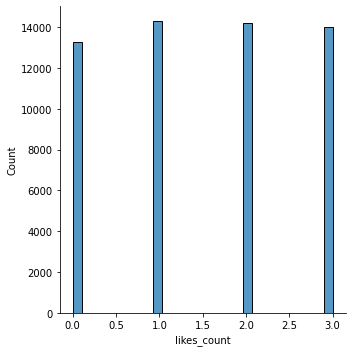

In [6]:
sns.displot(TRAIN_DATA["likes_count"])

In [7]:
HEADERS = list(TRAIN_DATA.columns)
a = ic(HEADERS)

ic| HEADERS: ['id',
              'conversation_id',
              'created_at',
              'user_id',
              'username',
              'name',
              'place',
              'tweet',
              'language',
              'mentions',
              'urls',
              'photos',
              'hashtags',
              'cashtags',
              'link',
              'quote_url',
              'video',
              'thumbnail',
              'reply_to',
              'likes_count']


<AxesSubplot:title={'center':'Video Count'}, xlabel='video', ylabel='Count'>

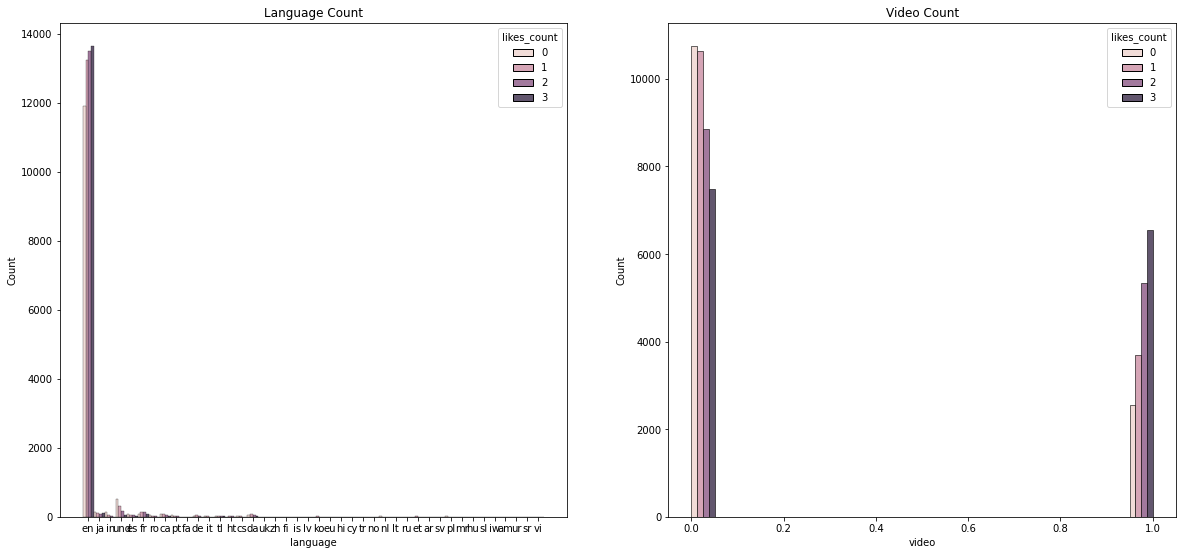

In [8]:
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(2, 2, 1)
ax.set_title("Language Count")
sns.histplot(ax=ax, data=TRAIN_DATA, x="language", hue="likes_count", multiple="dodge")

ax = plt.subplot(2, 2, 2)
ax.set_title("Video Count")
sns.histplot(ax=ax, data=TRAIN_DATA, x="video", hue="likes_count", multiple="dodge")


# Translate Training Data

In [9]:
def generate_tweet_message_normalized_column(
        pd_data, 
        MAX_LENGTH = None, 
        DELIMITER: str = '; |, |、|。| \) | \( | \[ | \] | ',
        KEYS_TO_REMOVE: List[str] = ["http", "arXiv", "https"]
    ):
    if MAX_LENGTH is None:
        MAX_LENGTH, d = pd_data.shape
    tweet_data = []
    for i in range(MAX_LENGTH):
        messages = pd_data['tweet'][i]
        # separate delimiter:
        messages = re.split(DELIMITER, messages)
        # remove keys:
        new_messages = []
        for msg in messages:
            no_key = True
            for key in KEYS_TO_REMOVE: # tags to be removed
                if key in msg:
                    no_key = False
            if no_key and len(msg) > 0:
                # split:
                new_messages.extend(jieba.lcut(msg, cut_all=True)) # split east asian
        tweet_data.append(new_messages)

    pd_data['norm-tweet'] = tweet_data

generate_tweet_message_normalized_column(
    pd_data = TRAIN_DATA
)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.520 seconds.
Prefix dict has been built successfully.


In [10]:
# save frame
TRAIN_DATA.to_csv(abspath('processed_data/train.csv'))

In [11]:
# sample:
TRAIN_DATA.head(10)

,id,conversation_id,created_at,user_id,username,name,place,tweet,language,mentions,...,photos,hashtags,cashtags,link,quote_url,video,thumbnail,reply_to,likes_count,norm-tweet
0,0,807288227279306753,2016-12-09 10:18:06 PST,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICLR2017 Semi-Supervised Detection of Extreme...,en,[],...,[],['iclr2017'],[],https://twitter.com/arxiv_in_review/status/807...,NaN,0,NaN,[],1,"[#, ICLR2017, Semi, -, Supervised, Detection, ..."
1,1,875332448145616896,2017-06-15 05:41:33 PDT,1582593798,lymphomahub,Lymphoma Hub,NaN,#ICML14 #icml2017 @JudithTrotman1 about to pre...,en,"[{'screen_name': 'judithtrotman1', 'name': 'ju...",...,['https://pbs.twimg.com/media/DCXONWrWAAAX9Bg....,"['icml14', 'icml2017', 'lymphoma', 'hl']",[],https://twitter.com/lymphomahub/status/8753324...,NaN,1,https://pbs.twimg.com/media/DCXONWrWAAAX9Bg.jpg,[],1,"[#, ICML14, #, icml2017, @, JudithTrotman1, ab..."
2,2,1203887042528206849,2019-12-08 20:00:12 PST,207634580,meetvancouver,Vancouver CVB,NaN,#NeurIPS2019 tip! We put together dining guide...,en,[],...,['https://pbs.twimg.com/media/ELUQ4hNXkAACSn1....,"['neurips2019', 'vancouver']",[],https://twitter.com/MeetVancouver/status/12038...,NaN,1,https://pbs.twimg.com/media/ELUQ4hNXkAACSn1.jpg,[],1,"[#, NeurIPS2019, tip, !, We, put, together, di..."
3,3,1139567821820555265,2019-06-14 09:18:35 PDT,228283891,thegradient,Hossein Mobahi,NaN,@roydanroy giving a fantastic talk at #ICML #I...,en,[],...,['https://pbs.twimg.com/media/D9CO3KyVAAErkPU....,"['icml', 'icml19', 'icml2019']",[],https://twitter.com/TheGradient/status/1139567...,NaN,1,https://pbs.twimg.com/media/D9CO3KyVAAErkPU.jpg,[],2,"[@, roydanroy, giving, a, fantastic, talk, at,..."
4,4,1017123008102719488,2018-07-11 12:06:37 PDT,873936709,rllabmcgill,Reasoning & Learning,NaN,Congrats to Matt Smith for presenting his pape...,en,[],...,['https://pbs.twimg.com/media/Dh2LL5HW4AAEi_q....,['icml2018'],[],https://twitter.com/rllabmcgill/status/1017123...,NaN,1,https://pbs.twimg.com/media/Dh2LL5HW4AAEi_q.jpg,[],3,"[Congrats, to, Matt, Smith, for, presenting, h..."
5,5,1183098703080546306,2019-10-12 12:14:46 PDT,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICLR2020 Rate-Distortion Optimization Guided ...,en,[],...,[],['iclr2020'],[],https://twitter.com/arxiv_in_review/status/118...,NaN,0,NaN,[],0,"[#, ICLR2020, Rate, -, Distortion, Optimizatio..."
6,6,806403305563951104,2016-12-06 23:41:44 PST,268360184,dhpmrou,David Rousseau,NaN,#nips2016 poster automatic translator playing ...,en,[],...,['https://pbs.twimg.com/media/CzDriAjWgAAyoJb....,"['nips2016', 'alphago']",[],https://twitter.com/dhpmrou/status/80640330556...,NaN,1,https://pbs.twimg.com/media/CzDriAjWgAAyoJb.jpg,[],2,"[#, nips2016, poster, automatic, translator, p..."
7,7,1204153918902677504,2019-12-09 13:40:41 PST,1073038501933764608,umeki_murc,梅木 秀雄（三菱UFJリサーチ＆コンサルティング）,NaN,#NeurIPS2019 ニューラルアーキテクチャ情報システム、実質ディープラーニング最大級...,ja,[],...,['https://pbs.twimg.com/media/ELYDjivX0AIVxg8....,['neurips2019'],[],https://twitter.com/umeki_murc/status/12041539...,NaN,1,https://pbs.twimg.com/media/ELYDjivX0AIVxg8.jpg,[],1,"[#, NeurIPS2019, ニューラルアーキテクチャ, 情, 報, システム, 実, ..."
8,8,1114411088467169282,2019-04-05 23:14:42 PDT,756502711621726209,arxiv_in_review,arXiv in review,NaN,#ICML2019 Progressive Stochastic Binarization ...,en,[],...,[],['icml2019'],[],https://twitter.com/arxiv_in_review/status/111...,NaN,0,NaN,[],1,"[#, ICML2019, Progressive, Stochastic, Binariz..."
9,9,806904779729289216,2016-12-08 08:54:25 PST,315636336,dribnet,dribnet,NaN,Honoured to get @NipsConference demonstration ...,en,"[{'screen_name': 'nipsconference', 'name': 'ni...",...,['https://pbs.twimg.com/media/CzKzXJfWIAA0c6e....,['nips2016'],[],https://twitter.com/dribnet/status/80690477972...,NaN,1,https://pbs.twimg.com/media/CzKzXJfWIAA0c6e.jpg,[],3,"[Honoured, to, get, @, NipsConference, demonst..."


In [12]:
UNIQ_LANG = TRAIN_DATA["language"].unique().tolist()

for lang in UNIQ_LANG:
    index = TRAIN_DATA.index[TRAIN_DATA["language"] == lang].tolist()[0]
    print(lang, " >", TRAIN_DATA["norm-tweet"][index])

en  > ['#', 'ICLR2017', 'Semi', '-', 'Supervised', 'Detection', 'of', 'Extreme', 'Weather', 'Events', 'in', 'Large', 'Climate', 'Datasets', '.']
ja  > ['#', 'NeurIPS2019', 'ニューラルアーキテクチャ', '情', '報', 'システム', '実', '質', 'ディープラーニング', '最大', '級', 'の', '国', '際', '学会', 'がカナダバンクーバーで', '開', '幕', '学会', 'セッション', '初日', 'の', '月', '曜', 'は', '朝', '6', ':', '30', 'から', '登', '録', '受', '付', 'デスクオープン', 'のはずがトラブルで', '約', '1', '時', '間', '遅', 'れ', 'w', '長', '蛇', 'の', '列', 'に', '8', ':', '30', 'からのチュートリアルに', '多数', '参加', 'していた']
in  > ['RT', 'ICLR', 'Intercept', 'Pharmaceuticals', 'Inc', '.', 'Company', 'Info', '$', 'ICLR', '$', 'HD', '$', 'GERN', '$', 'RNX', '.', 'TO', '#', 'ICLR', '#', 'stoc', '…']
und  > ['@', 'ADRIANSYSNET', '#', 'ForeignFighters', '&', 'amp', '#', 'ForeignTerroristFighters', ':', 'An', '#', 'InternationalLaw', '&', 'amp', '#', 'HumanRightsPerspective', '2016', '#', 'ICLR']
es  > ['Rebel', '#', 'NeurIPS2018']
fr  > ['.', '@', 'JackieForien', 'se', 'trouve', 'à', '#', 'NeurIPS2018', 'à', 'Mo

# Let's try NLP
tweet -> likes

In [13]:

N_TRAIN = 1000 # max:55824
N_TEST = 1000

# gen pytorch data:
def pandas2pytorch(
    pd_data,
    x_tag,
    y_tag,
    range
):
    return [(msg, like) for msg, like in zip(pd_data[x_tag][range[0]:range[1]], pd_data[y_tag][range[0]:range[1]])]

pytorch_data_train = pandas2pytorch(
    pd_data = TRAIN_DATA,
    x_tag = "norm-tweet", y_tag = "likes_count",
    range =[0, N_TRAIN]
)
pytorch_data_test = pandas2pytorch(
    pd_data = TRAIN_DATA,
    x_tag = "norm-tweet", y_tag = "likes_count",
    range =[N_TRAIN, N_TRAIN+N_TEST]
)

ic(np.shape(pytorch_data_train))
ic(np.shape(pytorch_data_test))


/home/jx/JXProject/jx_env/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
ic| np.shape(pytorch_data_train): (1000, 2)
ic| np.shape(pytorch_data_test): (1000, 2)


(1000, 2)

In [14]:
# generate a word to index:
word_to_ix = {}
word_count = {}
for sent, _ in pytorch_data_train + pytorch_data_test:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
            word_count[word] = 0
        else:
            word_count[word] += 1
            
VOCAB_SIZE = len(word_to_ix)
ic(VOCAB_SIZE)


ic| VOCAB_SIZE: 9830


9830

In [15]:
# sample top bag of words
word_count_top_100 = sorted(word_count.items(), key=lambda x:-x[1])[:100]
ic(word_count_top_100)


ic| word_count_top_100: [('#', 3697),
                         ('.', 1926),
                         ('@', 1404),
                         ('the', 1013),
                         ('to', 956),
                         ('and', 754),
                         ('at', 709),
                         ('-', 680),
                         ('of', 637),
                         ('for', 620),
                         (':', 619),
                         ('in', 567),
                         ('!', 507),
                         ('a', 476),
                         ('on', 471),
                         ("'", 413),
                         ('is', 355),
                         ('"', 316),
                         ('with', 314),
                         ('_', 308),
                         ('AI', 275),
                         ('I', 255),
                         (')', 244),
                         ('our', 237),
                         ('(', 232),
                         ('NeurIPS2019', 227),
      

[('#', 3697),
 ('.', 1926),
 ('@', 1404),
 ('the', 1013),
 ('to', 956),
 ('and', 754),
 ('at', 709),
 ('-', 680),
 ('of', 637),
 ('for', 620),
 (':', 619),
 ('in', 567),
 ('!', 507),
 ('a', 476),
 ('on', 471),
 ("'", 413),
 ('is', 355),
 ('"', 316),
 ('with', 314),
 ('_', 308),
 ('AI', 275),
 ('I', 255),
 (')', 244),
 ('our', 237),
 ('(', 232),
 ('NeurIPS2019', 227),
 ('[', 227),
 ('by', 227),
 ('s', 226),
 ('you', 222),
 ('Learning', 210),
 ('NeurIPS2020', 202),
 ('from', 197),
 ('])', 185),
 ('NeurIPS2018', 185),
 ('?', 182),
 ('\\', 180),
 ('this', 177),
 ('cs', 170),
 ('about', 163),
 ('that', 159),
 ('be', 157),
 ('/', 156),
 ('workshop', 155),
 ('NIPS2017', 155),
 ('are', 154),
 ('paper', 141),
 ('&', 141),
 ('LG', 135),
 ('learning', 132),
 ('more', 130),
 ('ML', 127),
 ('work', 124),
 ('amp', 124),
 ('out', 120),
 ('NeurIPS', 120),
 ('it', 118),
 ('’', 113),
 ('talk', 107),
 ('The', 106),
 ('poster', 104),
 ('we', 102),
 ('We', 97),
 ('papers', 96),
 ('have', 93),
 ('ICML2019',

## TRAIN:

In [16]:
# LOAD NET: ----- ----- ----- ----- ----- ----- ----- ----- ----- ----- #
# check device:
# hardware-acceleration
device = None
if torch.cuda.is_available():
    print("[ALERT] Attempt to use GPU => CUDA:0")
    device = torch.device("cuda:0")
else:
    print("[ALERT] GPU not found, use CPU!")
    device =  torch.device("cpu")
# MODEL_DICT["VGG11"].to(device)

[ALERT] Attempt to use GPU => CUDA:0


In [31]:
data = pytorch_data_train
test_data = pytorch_data_test

VOCAB_SIZE = len(word_to_ix)
NUM_LABELS = 4


class BoWClassifier(nn.Module):  # inheriting from nn.Module!
    def __init__(self, num_labels, vocab_size):
        # calls the init function of nn.Module.  Dont get confused by syntax,
        # just always do it in an nn.Module
        super(BoWClassifier, self).__init__()

        # Define the parameters that you will need.  In this case, we need A and b,
        # the parameters of the affine mapping.
        # Torch defines nn.Linear(), which provides the affine map.
        # Make sure you understand why the input dimension is vocab_size
        # and the output is num_labels!
        self.linear = nn.Linear(vocab_size, num_labels)

        # NOTE! The non-linearity log softmax does not have parameters! So we don't need
        # to worry about that here

    def forward(self, bow_vec):
        # Pass the input through the linear layer,
        # then pass that through log_softmax.
        # Many non-linearities and other functions are in torch.nn.functional
        return F.log_softmax(self.linear(bow_vec), dim=1)


def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for word in sentence:
        vec[word_to_ix[word]] += 1
    return vec.view(1, -1)


def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])


model = BoWClassifier(NUM_LABELS, VOCAB_SIZE)

# the model knows its parameters.  The first output below is A, the second is b.
# Whenever you assign a component to a class variable in the __init__ function
# of a module, which was done with the line
# self.linear = nn.Linear(...)
# Then through some Python magic from the PyTorch devs, your module
# (in this case, BoWClassifier) will store knowledge of the nn.Linear's parameters
for param in model.parameters():
    ic(param)

# To run the model, pass in a BoW vector
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    sample = data[0]
    bow_vector = make_bow_vector(sample[0], word_to_ix)
    log_probs = model(bow_vector)
    ic(bow_vector)
    ic(log_probs)


ic| param: Parameter containing:
           tensor([[ 0.0017, -0.0011, -0.0014,  ..., -0.0084, -0.0028, -0.0011],
                   [ 0.0023,  0.0016,  0.0082,  ..., -0.0001, -0.0101, -0.0079],
                   [ 0.0078, -0.0098,  0.0036,  ..., -0.0033,  0.0023, -0.0083],
                   [ 0.0047, -0.0052,  0.0066,  ..., -0.0057, -0.0086, -0.0035]],
                  requires_grad=True)
ic| param: Parameter containing:
           tensor([ 0.0096, -0.0086,  0.0068,  0.0025], requires_grad=True)
ic| bow_vector: tensor([[1., 1., 1.,  ..., 0., 0., 0.]])
ic| log_probs: tensor([[-1.3618, -1.4040, -1.4080, -1.3722]])


In [32]:
label_to_ix = {0: 0, 1: 1, 2:2, 3:3}

make_target(3, label_to_ix)


tensor([3])

In [34]:

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# ------- ------- ------- TRAIN:
report = ProgressReport()

num_epochs = 10
# Usually you want to pass over the training data several times.
# 100 is much bigger than on a real data set, but real datasets have more than
# two instances.  Usually, somewhere between 5 and 30 epochs is reasonable.
for epoch in range(num_epochs):
    print("> epoch {}/{}:".format(epoch + 1, num_epochs))
    
    train_loss_sum, train_acc_sum, train_n, train_start = 0.0, 0.0, 0, time.time()
    test_loss_sum, test_acc_sum, test_n, test_start = 0.0, 0.0, 0, time.time()

    # TRAIN -----------------------------:
    for instance, label in data:
        # Step 1. Remember that PyTorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Make our BOW vector and also we must wrap the target in a
        # Tensor as an integer. For example, if the target is SPANISH, then
        # we wrap the integer 0. The loss function then knows that the 0th
        # element of the log probabilities is the log probability
        # corresponding to SPANISH
        bow_vec = make_bow_vector(instance, word_to_ix)
        target = make_target(label, label_to_ix)

        # Step 3. Run our forward pass.
        log_probs = model(bow_vec)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()

        train_n += 1
    
    train_ellapse = time.time() - train_start
    
    # TEST -----------------------------:
    # with torch.no_grad():
    for instance, label in test_data:
        bow_vec = make_bow_vector(instance, word_to_ix)
        log_probs = model(bow_vec)
        ic(log_probs)
  
        # Log summay:
        test_loss_sum += loss.item()
        test_acc_sum += (log_probs.argmax(dim=1) == label).sum().item()

        test_n += 1
    
    test_ellapse = time.time() - test_start
    
    # Store ------:
    report.append(
        epoch         = epoch,
        train_loss    = train_loss_sum / train_n,
        train_acc     = train_acc_sum / train_n,
        train_time    = train_ellapse,
        test_loss     = test_loss_sum / test_n,
        test_acc      = test_acc_sum / test_n,
        test_time     = test_ellapse,
        learning_rate = 0,
        verbose       = True
    )

> epoch 1/10:
ic| log_probs: tensor([[-0.8671, -1.0212, -1.5927, -4.1154]], grad_fn=<LogSoftmaxBackward>)


NameError: name 'y_prediction' is not defined